# Train model with Arcface

In [1]:
import numpy as np

import tensorflow.keras.datasets.mnist as mnist

from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense
)

from modules.arcface import ArcFaceBlock, ArcFaceLoss

# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data
x_train = x_train[:, :, :, np.newaxis].astype('float32') / 255
x_test = x_test[:, :, :, np.newaxis].astype('float32') / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [2]:
print('Train dataset has %s images of shape %s' % (x_train.shape[0], x_train.shape[1:]))
print('Train dataset has %s images of shape %s' % (x_test.shape[0], x_test.shape[1:]))

Train dataset has 60000 images of shape (28, 28, 1)
Train dataset has 10000 images of shape (28, 28, 1)


In [3]:
val_size = 10000

y_val = y_train[-val_size:]
x_val = x_train[-val_size:]
y_train = y_train[:-val_size]
x_train = x_train[:-val_size]

In [4]:
# Create Neural Network

input_shape = (28, 28, 1)
target_tensor = (10,)

inputs = Input(shape=input_shape)
label = Input(shape=target_tensor)

x = Conv2D(16, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(128, name='features_vector', kernel_initializer='he_normal')(x)

outputs = ArcFaceBlock(n_classes = 10)(x)
m = Model(inputs=inputs, outputs=outputs, name="mnist_arcface")

# Add ArcFace Block
ARGS = {'m':0.5, 's':32}
m.compile(
    optimizer = 'rmsprop', 
    loss = ArcFaceLoss(**ARGS),
    metrics=[CategoricalAccuracy()]
)

m.summary()

Model: "mnist_arcface"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)        

In [5]:
# Hyperparmeters
BATCH_SIZE = 1024
EPOCHS = 10

In [6]:
# Train
history = m.fit(
    x=x_train, 
    y=y_train, 
    validation_data=(x_val, y_val), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

Epoch 1/10
49/49 [==============================] - 7s 131ms/step - loss: 13.4990 - categorical_accuracy: 0.7448 - val_loss: 11.9053 - val_categorical_accuracy: 0.8757
Epoch 2/10
49/49 [==============================] - 6s 127ms/step - loss: 10.5693 - categorical_accuracy: 0.8922 - val_loss: 8.9036 - val_categorical_accuracy: 0.9174
Epoch 3/10
49/49 [==============================] - 6s 129ms/step - loss: 9.4766 - categorical_accuracy: 0.9222 - val_loss: 8.6281 - val_categorical_accuracy: 0.9104
Epoch 4/10
49/49 [==============================] - 6s 130ms/step - loss: 8.8271 - categorical_accuracy: 0.9366 - val_loss: 7.5258 - val_categorical_accuracy: 0.9503
Epoch 5/10
49/49 [==============================] - 6s 129ms/step - loss: 8.4502 - categorical_accuracy: 0.9445 - val_loss: 7.0275 - val_categorical_accuracy: 0.9586
Epoch 6/10
49/49 [==============================] - 6s 129ms/step - loss: 8.2141 - categorical_accuracy: 0.9486 - val_loss: 6.9057 - val_categorical_accuracy: 0.9611
E

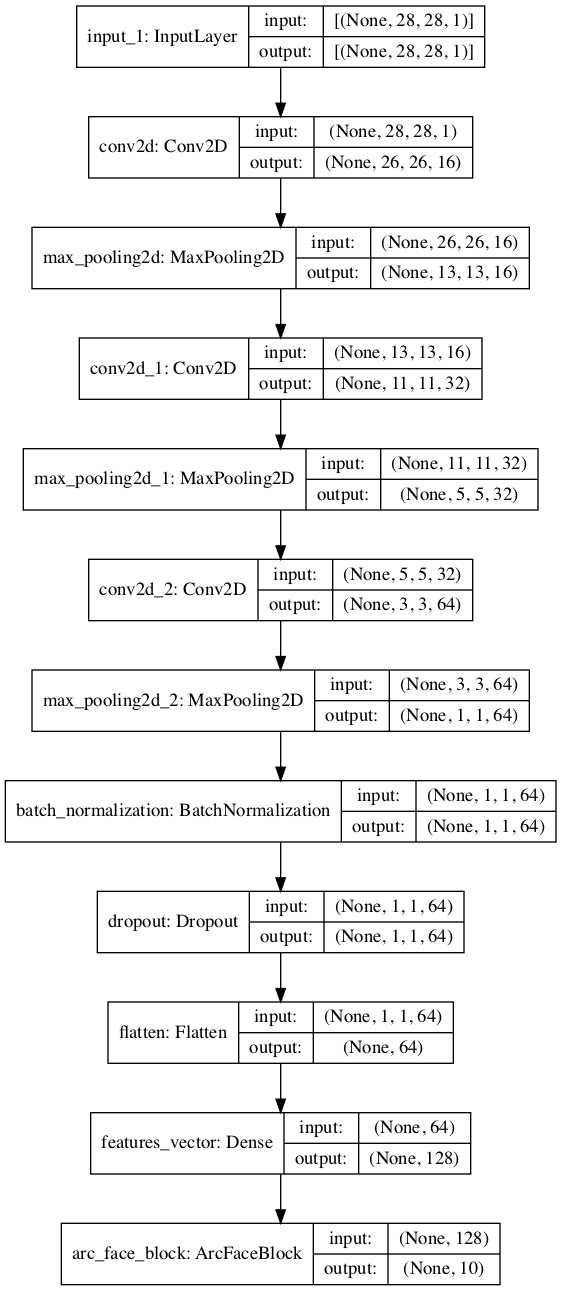

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(m, to_file='arface_model.png', show_shapes=True)

In [8]:
# history.history
# {
#    "loss": [...],
#    "val_los": [...],
#    "categorical_accuracy": [...],
#    "val_categorical_accuracy": [...],
# }

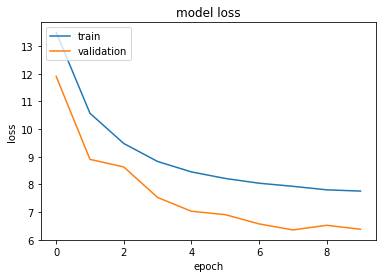

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

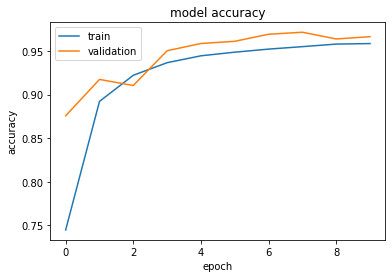

In [17]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
train_eval = m.evaluate(x_train, y_train)
val_eval = m.evaluate(x_val, y_val)
test_eval = m.evaluate(x_test, y_test)

model_accuracy = np.array([train_eval[1], val_eval[1], test_eval[1]]).min()

313/313 [==============================] - 1s 2ms/step - loss: 1.0967 - categorical_accuracy: 0.9712


In [25]:
print(f'Model Accuracy : {model_accuracy}')

Model Accuracy : 0.9663000106811523


In [ ]:
m_prod = Model(inputs=m.inputs, outputs= m.get_layer('features_vector').output, name="mnist_arcface")

In [11]:
m.save('../models/arcface-trained-model.h5')
m_prod.save('../models/arcface-inference-model.h5')